In [1]:
import numpy as np
import os
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

In [82]:
pwd = os.getcwd()
database_path = pwd[:-6] + "flightData/filtered_data/scenario5"

In [83]:
database_file_names = []
for root, dirs, files in os.walk(database_path):
    database_file_names = [os.path.join(root,file) for file in files]
#     print(database_file_names)

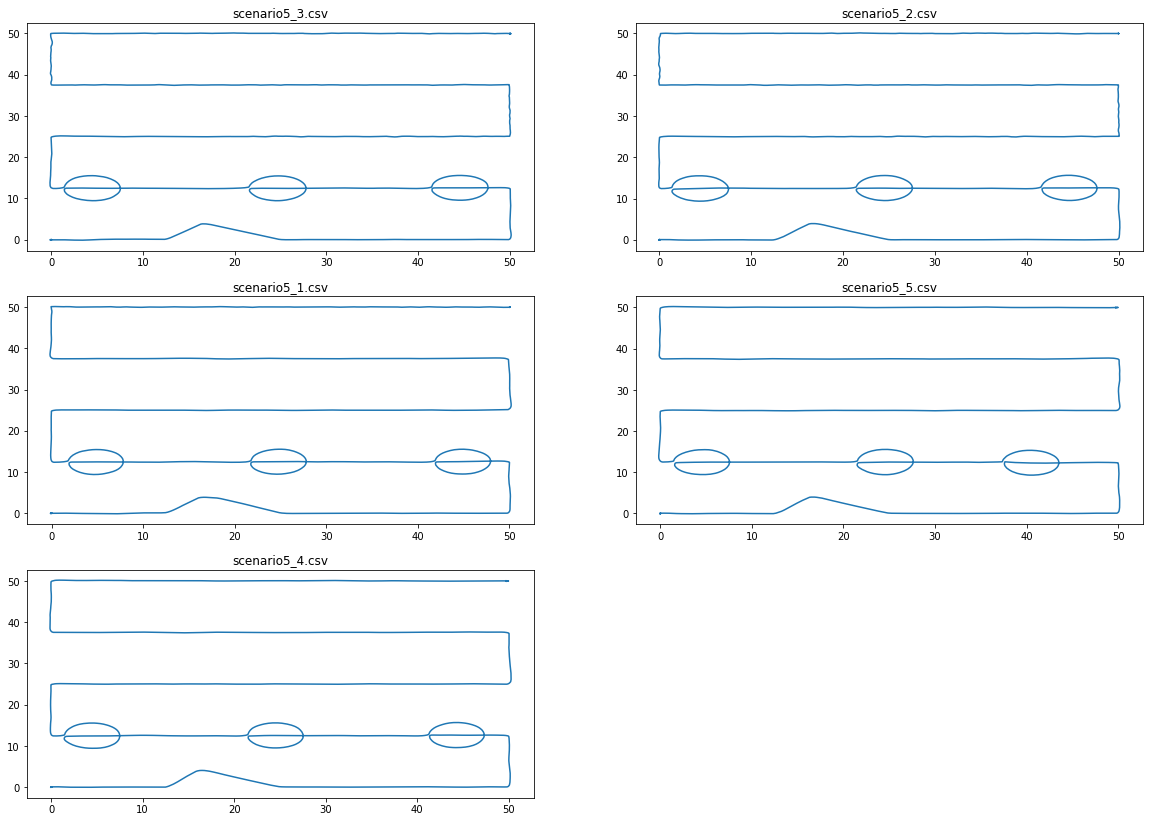

In [84]:
plt.figure(figsize=(20,125))
for i,file in enumerate(database_file_names):
    data = pd.read_csv(file)
#     print(file)
    x = data['x'].values
    y = data['y'].values
    plt.subplot(25,2,i+1)
    plt.plot(x,y)
    file = file.split("/")
    file = file[-1]
    plt.title(file)
#     print(i)

In [25]:
data.head()

,label,pitch,pitch_v,roll,roll_v,time,x,x_v,y,y_v,yaw,yaw_v,z,z_v
0,Hold,-0.0,0.0,0.0,0.0,1.589693e+09,-0.000006,-0.000833,-0.000001,-0.000182,0.0,0.0,0.000001,0.000533
1,Hold,-0.0,0.0,0.0,0.0,1.589693e+09,-0.000006,-0.000833,-0.000001,-0.000182,0.0,0.0,0.000001,0.000533
2,Hold,-0.0,0.0,0.0,0.0,1.589693e+09,-0.000032,-0.000290,-0.000025,-0.000753,0.0,0.0,0.000137,0.005525
3,Hold,-0.0,0.0,0.0,0.0,1.589693e+09,-0.000032,-0.000290,-0.000025,-0.000753,0.0,0.0,0.000137,0.005525
4,Hold,-0.0,0.0,0.0,0.0,1.589693e+09,-0.000006,0.001330,-0.000037,-0.000421,0.0,0.0,-0.000242,0.010795


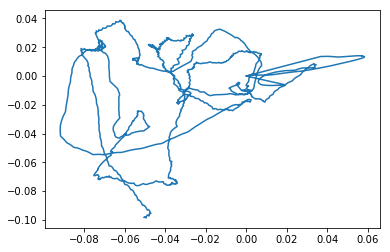